
## Assignment 5
Perform image segmentation on all images in the dataset, using the normalized cut algorithm running on the top of superpixels rather than on raw pixels. For each image compute an accuracy metric (which one it is up to you to decide) measuring the overlap between the segments identified by NCUT and the ground truth horse semantic segmentation. Provide a table summarizing the average segmentation accuracy on all images, plus present 2 examples of images that are well-segmented (according to the above defined metric).

Hint: in Python, you have an NCut implementation in the scikit-image library; in Matlab, you can use the original NCut implementation here. Superpixels are implemented both in Matlab as well as in OpenCV. Feel free to pickup the implementation you liked most (and motivate the choice).

# Superpixeling 

Superpixeling is a preprocessing step in image segmentation that consists in grouping together similar pixels to perform a cheap, local oversegmentation. The image processing library **scikit-image** was utilized for image processing [1].



Reference:

[1] Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu, and the scikit-image contributors. scikit-image: Image processing in Python. PeerJ 2:e453 (2014) https://doi.org/10.7717/peerj.453


In [97]:
from skimage import segmentation, color, graph
from matplotlib import pyplot as plt
import numpy as np

from utils1 import * # contains methods to import the dataset and print images

In [98]:
# load the dataset
folder_path = '../datasets/weizmann_horse_db/horse'
images = load_images_from_folder(folder_path)

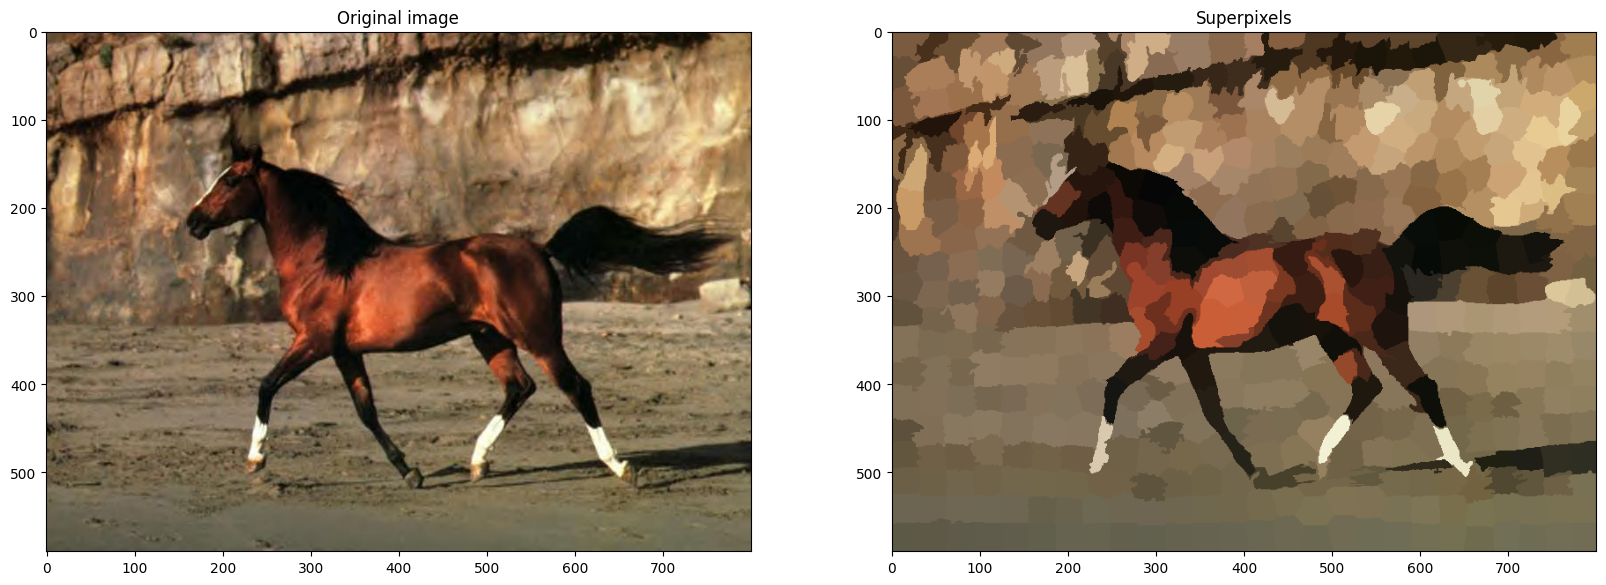

In [99]:
import cv2

image = images[0]

#image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

num_superpixels = 500

# Apply SLIC algorithm to generate superpixels
labels = segmentation.slic(image, n_segments=num_superpixels, compactness=20, start_label=1)
color_segment = color.label2rgb(labels, image, kind='avg')

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(color_segment)
ax[1].set_title('Superpixels')
plt.show()


RAG with 472 nodes and 1343 edges


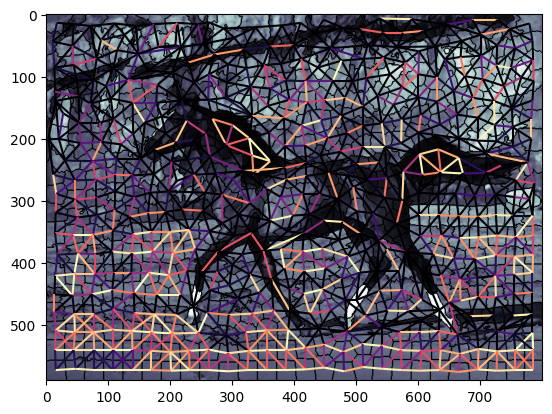

In [100]:
#RAG_distance = graph.rag_mean_color(image, labels, mode='distance')
#print(RAG_distance)
RAG_similarity = graph.rag_mean_color(image, labels, mode='similarity')
print(RAG_similarity)
#graph1 = graph.show_rag(labels=labels, rag=RAG_distance, image=image)
graph2 = graph.show_rag(labels=labels, rag=RAG_similarity, image=image)

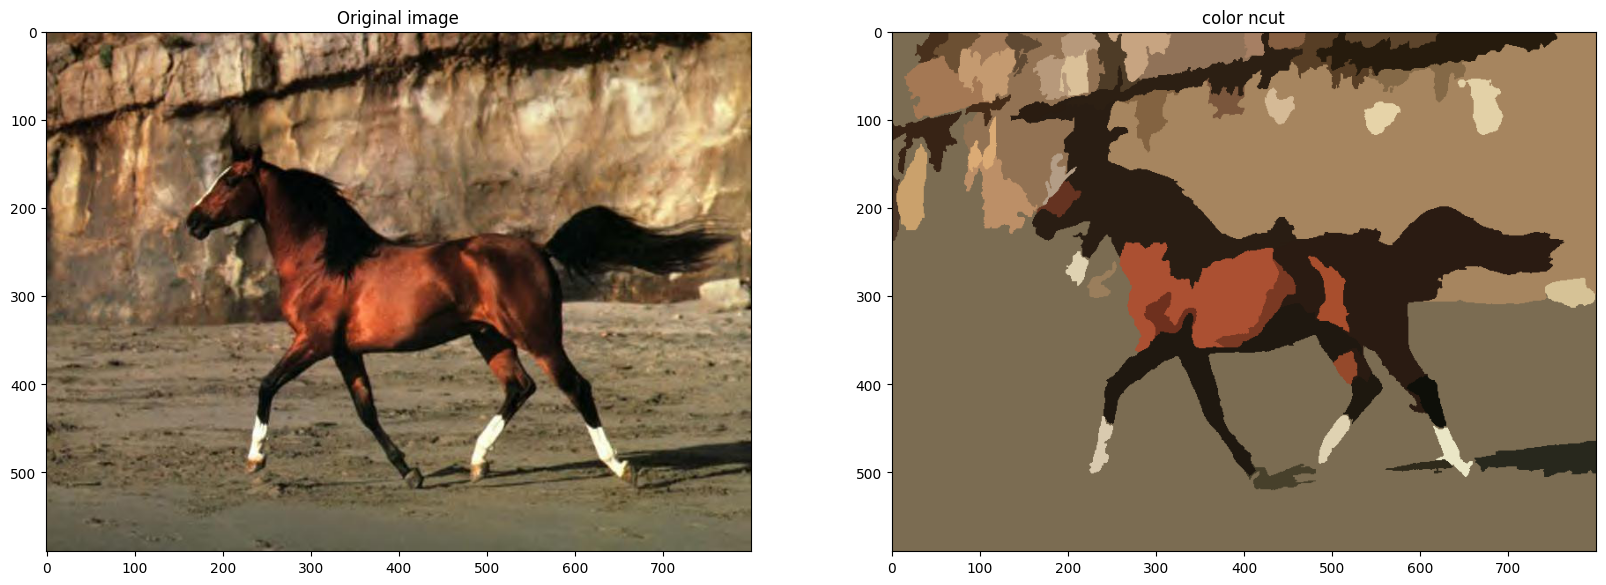

In [101]:
ncut = graph.cut_normalized(labels, rag=RAG_similarity)
color_ncut = color.label2rgb(ncut, image, kind='avg', bg_label=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(color_ncut)
ax[1].set_title('color ncut')
plt.show()

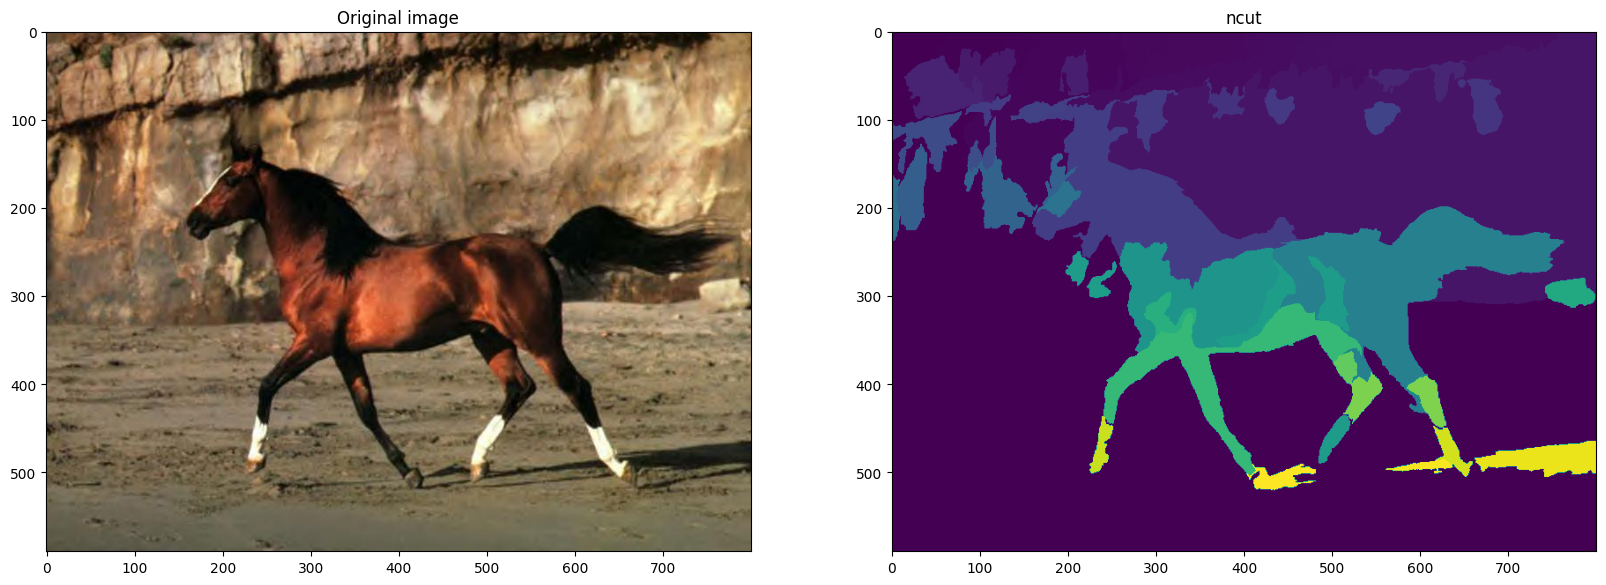

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(ncut)
ax[1].set_title('ncut')
plt.show()

In [103]:
grey_cut = color.rgb2gray(color_ncut)

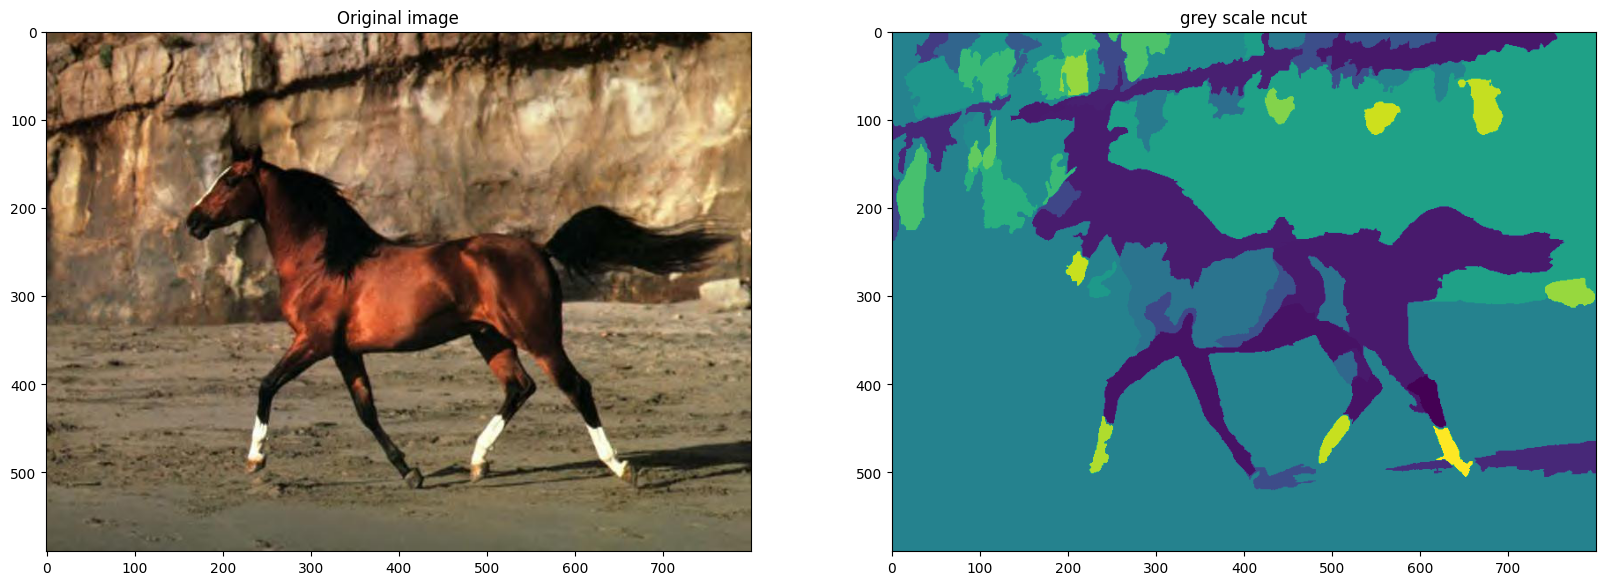

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(grey_cut)
ax[1].set_title('grey scale ncut')
plt.show()

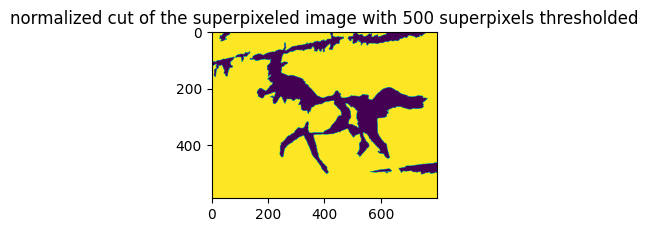

In [105]:
average = np.average(grey_cut)/2

ncut_threshold = grey_cut.copy()
ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1
print_image(ncut_threshold, f'normalized cut of the superpixeled image with {num_superpixels} superpixels thresholded')

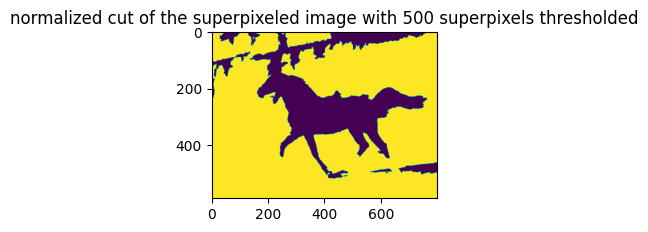

In [106]:
average = np.average(grey_cut)

ncut_threshold = grey_cut.copy()
ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1
print_image(ncut_threshold, f'normalized cut of the superpixeled image with {num_superpixels} superpixels thresholded')

In [107]:
from utils1 import load_images_from_folder
folder_path = '../datasets/weizmann_horse_db/mask'
imagess = load_images_from_folder(folder_path)

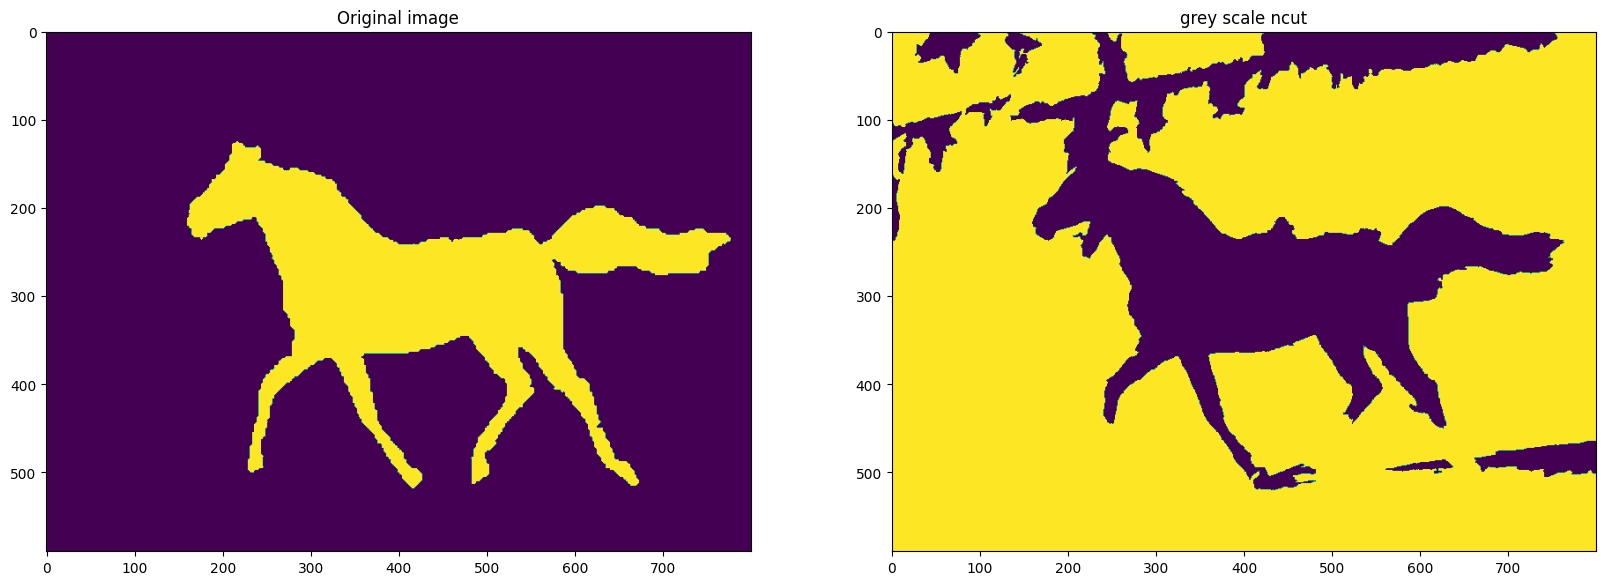

In [108]:
mask = imagess[0]
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(mask)
ax[0].set_title('Original image')
ax[1].imshow(ncut_threshold)
ax[1].set_title('grey scale ncut')
plt.show()

In [109]:
from sklearn.metrics import jaccard_score
import numpy as np


img_true=np.array(mask).ravel()
img_pred=np.array(ncut_threshold).ravel()
iou = max(jaccard_score(img_true, img_pred), jaccard_score(img_true, (1-img_pred)))

In [110]:
iou

0.6101824925190711

In [115]:
def ncut(image):
    labels = segmentation.slic(image, n_segments=500, compactness=20, start_label=1)
    #color_segment = color.label2rgb(labels, image, kind='avg')
    
    RAG_similarity = graph.rag_mean_color(image, labels, mode='similarity')
    ncut_ = graph.cut_normalized(labels, rag=RAG_similarity)
    color_ncut = color.label2rgb(ncut_, image, kind='avg')
    grey_cut = color.rgb2gray(color_ncut)

    return grey_cut

In [116]:
def metric(image1, mask):

    image = ncut(image1)

    ncut_threshold = image.copy()
    ncut_threshold2 = image.copy()
    
    average = np.average(image)

    ncut_threshold[ncut_threshold < average] = 0
    ncut_threshold[ncut_threshold >= average] = 1

    ncut_threshold2[ncut_threshold2 < average/2] = 0
    ncut_threshold2[ncut_threshold2 >= average/2] = 1

    img_true=np.array(mask).ravel()
    img_pred=np.array(ncut_threshold).ravel()
    img_pred2=np.array(ncut_threshold2).ravel()
    iou = max(jaccard_score(img_true, img_pred), jaccard_score(img_true, (1-img_pred)), 
              jaccard_score(img_true, img_pred2), jaccard_score(img_true, (1-img_pred2)))
    return iou

In [117]:
from tqdm import tqdm

accs = []

with tqdm(total=len(images), desc="image", colour='yellow') as pbar:
    for i in range(len(images)):
        accs.append(metric(images[i], imagess[i]))
        pbar.update(1)

image: 100%|██████████| 327/327 [1:21:24<00:00, 14.94s/it]   


In [120]:
accs2 = accs.copy()
accs2.sort()
bests = accs2[-2:]
bests

[0.9460050278718986, 0.9615406022151722]

In [122]:
bests_index = [accs.index(i) for i in bests]
bests_index

[127, 316]

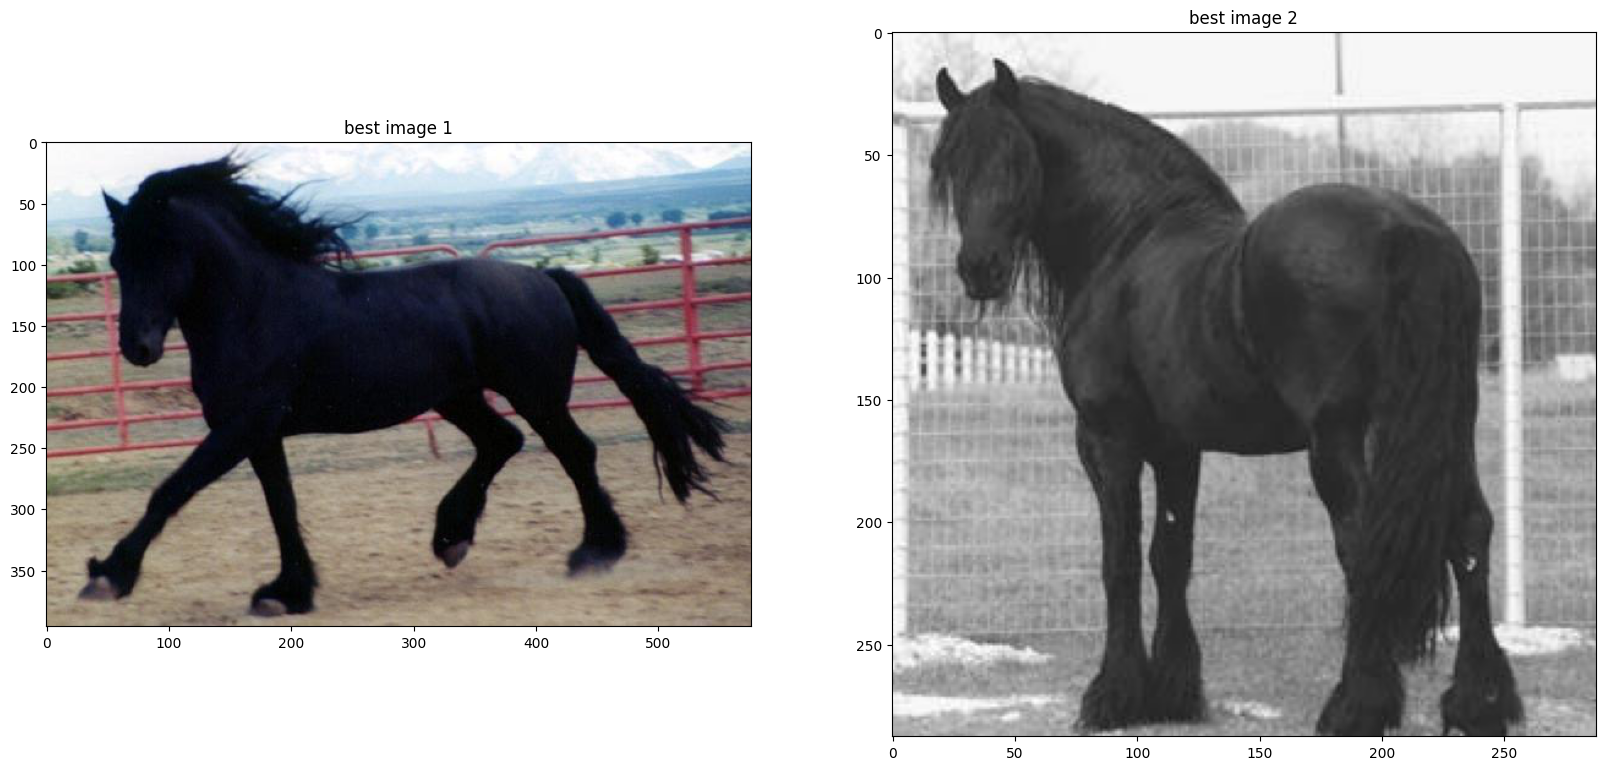

In [123]:
# print the 2 best images
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(images[bests_index[0]])
plt.title('best image 1')
plt.subplot(1, 2, 2)
plt.imshow(images[bests_index[1]])
plt.title('best image 2')
plt.show()



In [130]:
best1cut = ncut(images[bests_index[0]])
ncut_threshold = best1cut.copy()
ncut_threshold2 = best1cut.copy()

average = np.average(best1cut)

ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1

ncut_threshold2[ncut_threshold2 < average/2] = 0
ncut_threshold2[ncut_threshold2 >= average/2] = 1



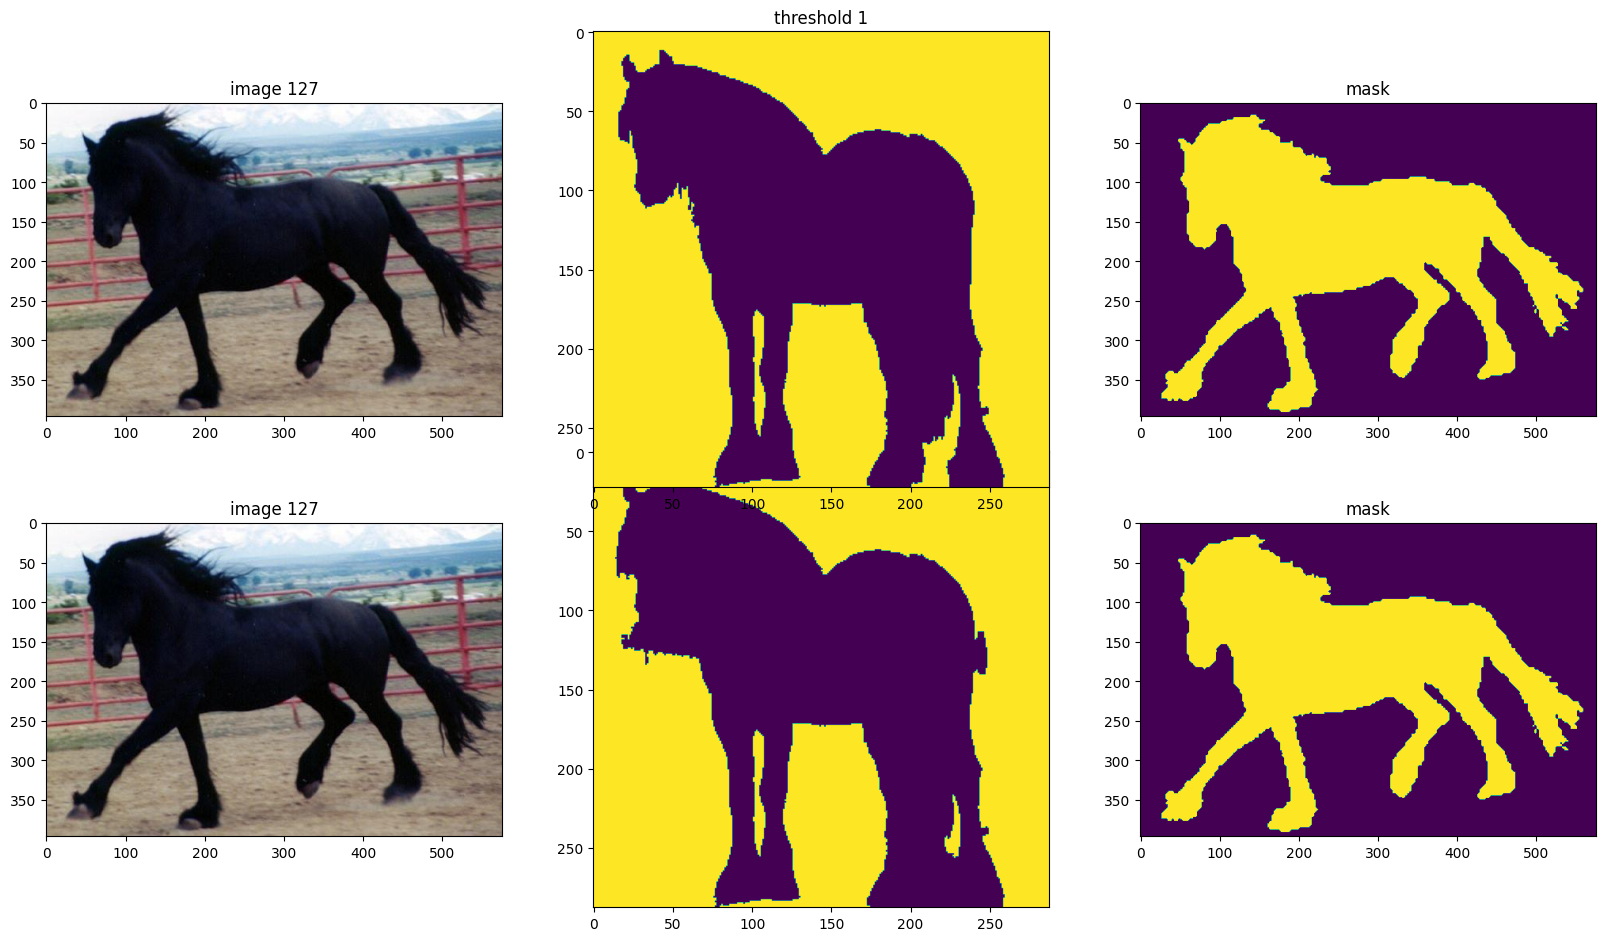

In [148]:
# print the first 3 image on the same line
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(images[bests_index[0]])
plt.title('image 127')
plt.subplot(1, 3, 2)
plt.imshow(ncut_threshold)
plt.title('threshold 2')
plt.subplot(1, 3, 3)
plt.imshow(imagess[bests_index[0]])
plt.title('mask')
plt.subplot(2, 3, 1)
plt.imshow(images[bests_index[0]])
plt.title('image 127')
plt.subplot(2, 3, 2)
plt.imshow(ncut_threshold2)
plt.title('threshold 1')
plt.subplot(2, 3, 3)
plt.imshow(imagess[bests_index[0]])
plt.title('mask')
plt.show()


In [144]:
best2cut = ncut(images[bests_index[1]])
ncut_threshold = best2cut.copy()
ncut_threshold2 = best2cut.copy()

average = np.average(best2cut)

ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1

ncut_threshold2[ncut_threshold2 < average/2] = 0
ncut_threshold2[ncut_threshold2 >= average/2] = 1

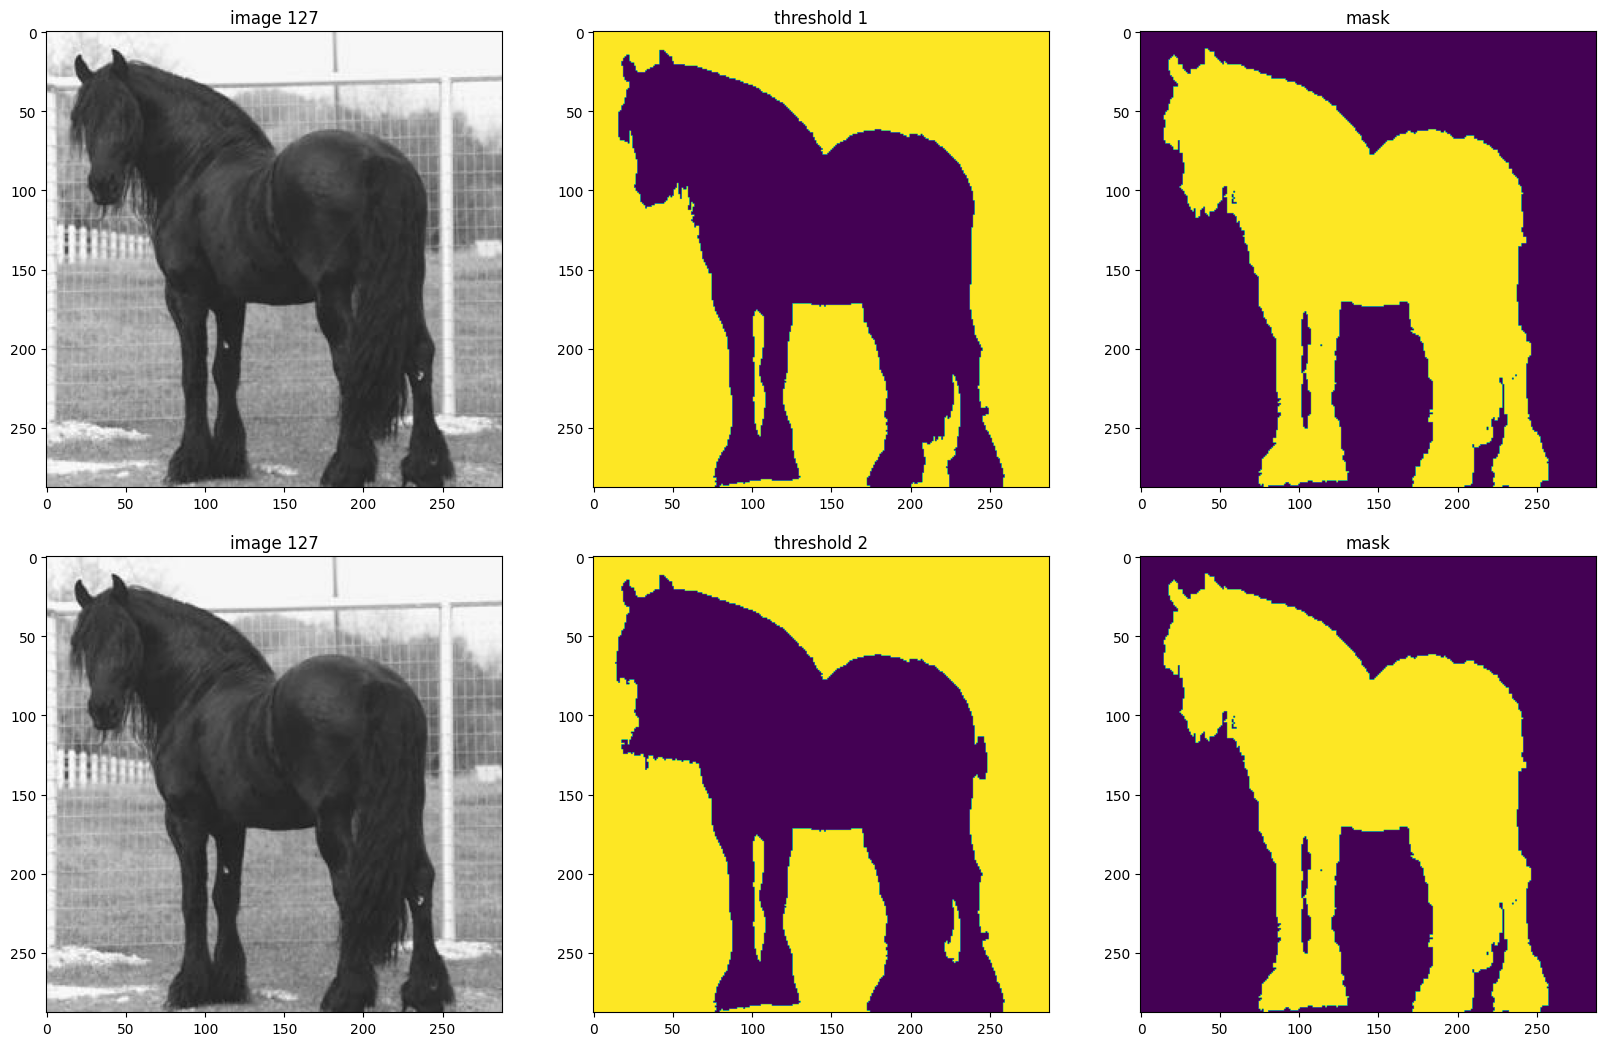

In [147]:
# print the first 3 image on the same line
plt.figure(figsize=(20, 25))
plt.subplot(1, 3, 1)
plt.imshow(images[bests_index[1]])
plt.title('image 127')
plt.subplot(1, 3, 2)
plt.imshow(ncut_threshold)
plt.title('threshold 2')
plt.subplot(1, 3, 3)
plt.imshow(imagess[bests_index[1]])
plt.title('mask')
plt.subplot(2, 3, 1)
plt.imshow(images[bests_index[1]])
plt.title('image 127')
plt.subplot(2, 3, 2)
plt.imshow(ncut_threshold2)
plt.title('threshold 1')
plt.subplot(2, 3, 3)
plt.imshow(imagess[bests_index[1]])
plt.title('mask')
plt.show()


In [191]:
worst = accs2[0]
worst_index = accs.index(worst)

worst2cut = ncut(images[worst_index])
ncut_threshold = worst2cut.copy()
ncut_threshold2 = worst2cut.copy()
ncut_threshold3 = worst2cut.copy()

average = np.average(worst2cut)

ncut_threshold[ncut_threshold < average] = 0
ncut_threshold[ncut_threshold >= average] = 1

ncut_threshold2[ncut_threshold2 < average/2] = 0
ncut_threshold2[ncut_threshold2 >= average/2] = 1

ncut_threshold3[ncut_threshold3 < average/1.83] = 0
ncut_threshold3[ncut_threshold3 >= average/1.83] = 1

In [162]:
average = np.mean(accs2)
average

0.4741729651399762

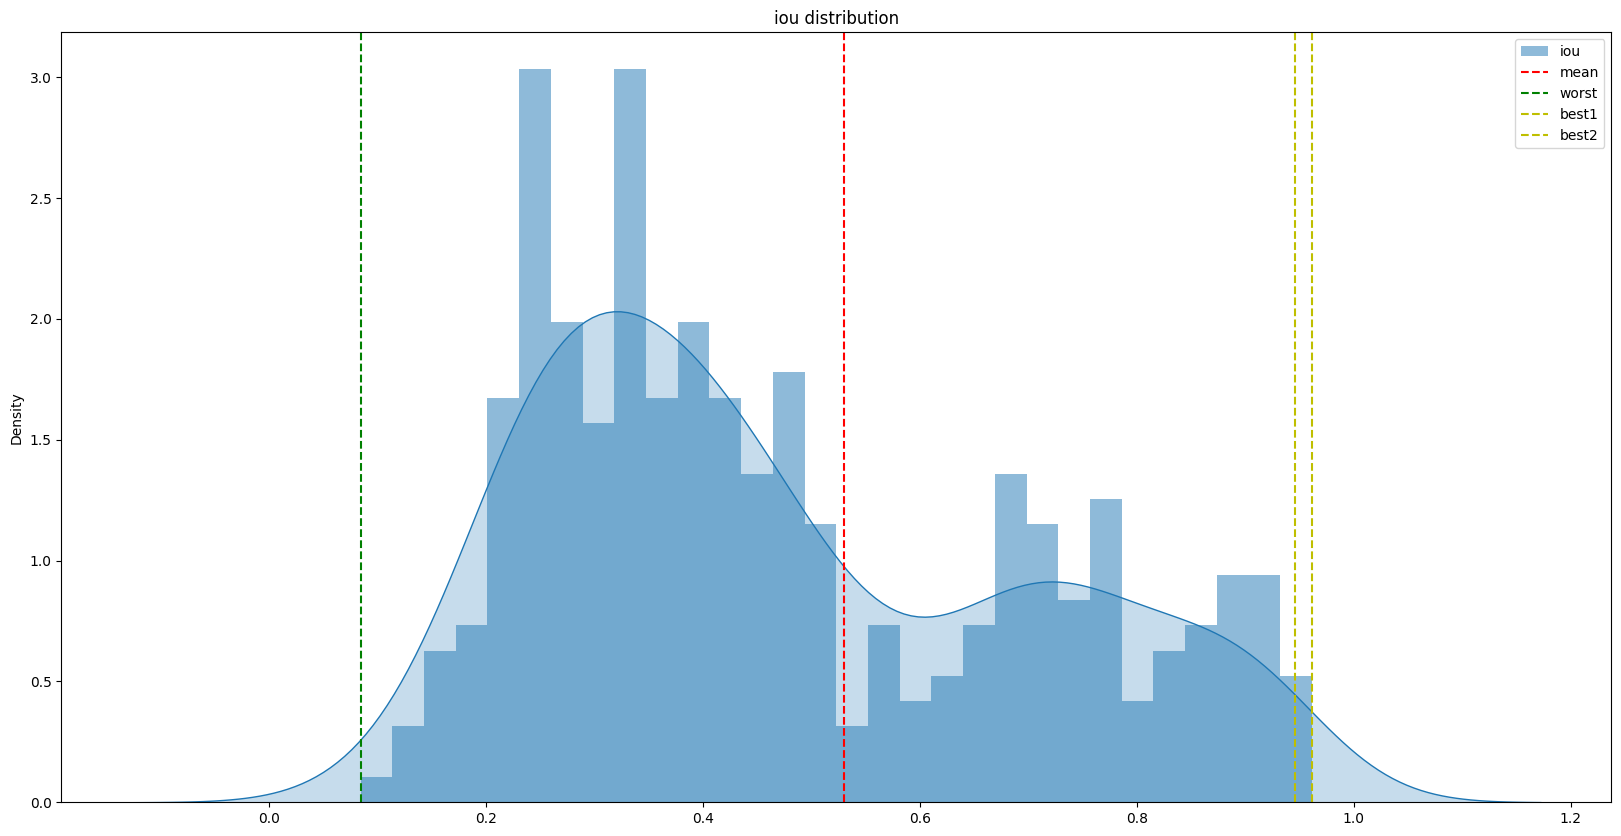

In [215]:
import seaborn as sns
plt.figure(figsize=(20, 10))
plt.hist(accs, bins=30, alpha=0.5, label='iou', density=True)
sns.kdeplot(accs, fill=True)
plt.axvline(x=average, color='r', linestyle='--', label='mean')
plt.axvline(x=worst, color='g', linestyle='--', label='worst')
plt.axvline(x=bests[0], color='y', linestyle='--', label='best1')
plt.axvline(x=bests[1], color='y', linestyle='--', label='best2')
plt.title('iou distribution')
plt.legend()
plt.show()



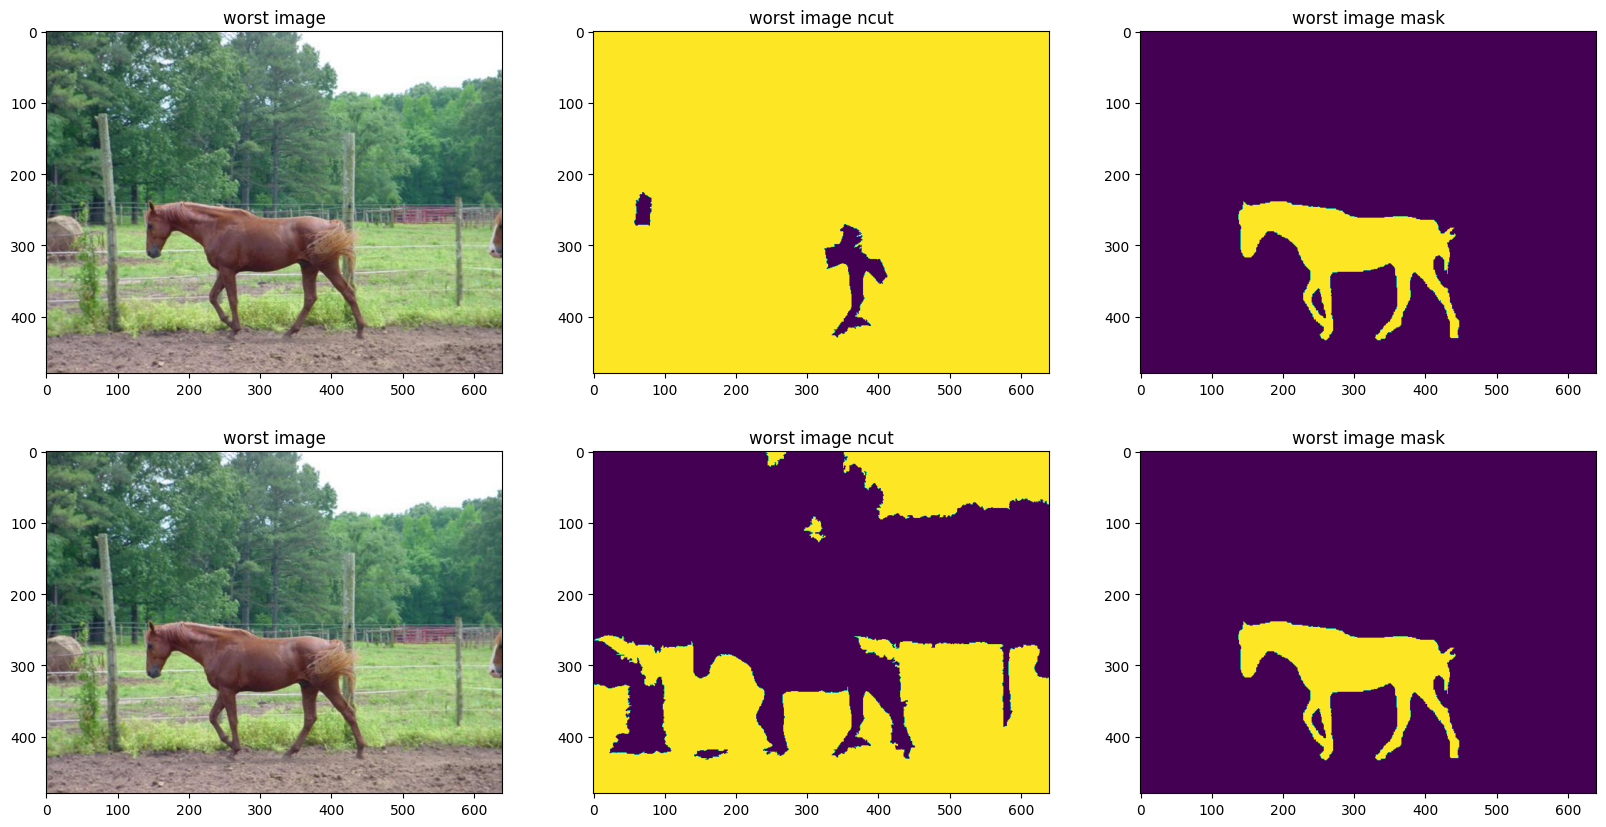

In [192]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(images[worst_index])
plt.title('worst image')
plt.subplot(1, 3, 2)
plt.imshow(ncut_threshold)
plt.title('worst image ncut')
plt.subplot(1, 3, 3)
plt.imshow(imagess[worst_index])
plt.title('worst image mask')
plt.subplot(2, 3, 1)
plt.imshow(images[worst_index])
plt.title('worst image')
plt.subplot(2, 3, 2)
plt.imshow(ncut_threshold2)
plt.title('worst image ncut')
plt.subplot(2, 3, 3)
plt.imshow(imagess[worst_index])
plt.title('worst image mask')
plt.show()

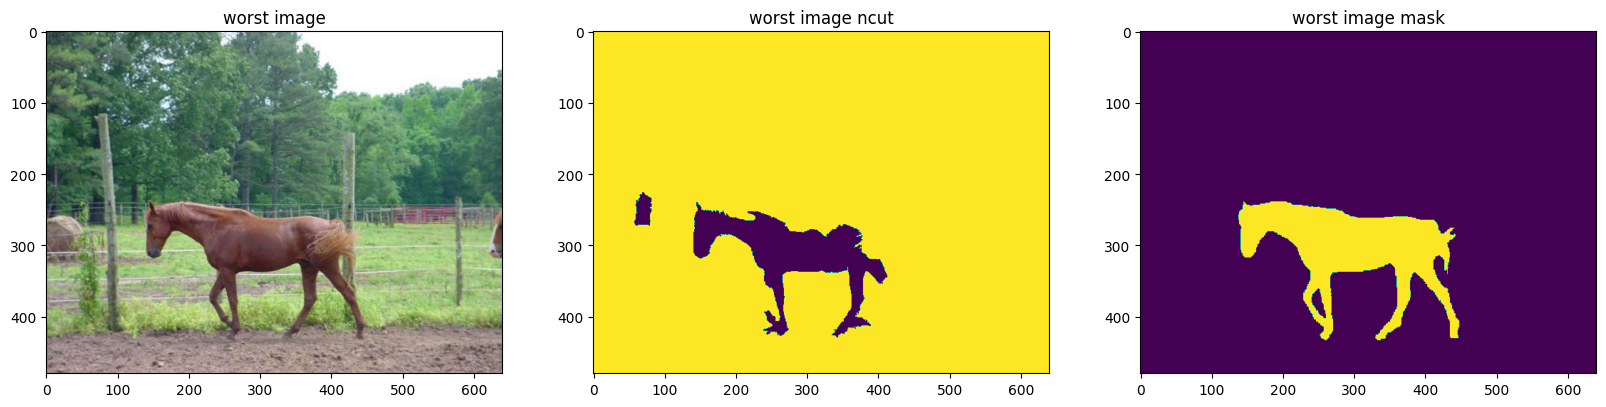

In [193]:
plt.figure(figsize=(20, 20))
plt.subplot(3, 3, 1)
plt.imshow(images[worst_index])
plt.title('worst image')
plt.subplot(3, 3, 2)
plt.imshow(ncut_threshold3)
plt.title('worst image ncut')
plt.subplot(3, 3, 3)
plt.imshow(imagess[worst_index])
plt.title('worst image mask')
plt.show()

In [196]:
img_pred = np.array(ncut_threshold3).ravel()
img_true = np.array(imagess[worst_index]).ravel()
iou = max(jaccard_score(img_true, img_pred), jaccard_score(img_true, (1-img_pred)))
iou

0.5968514219384794